# 实验3：第3方IP使用演示 AXI4-PWM IP 

## 1. 什么是PWM波形
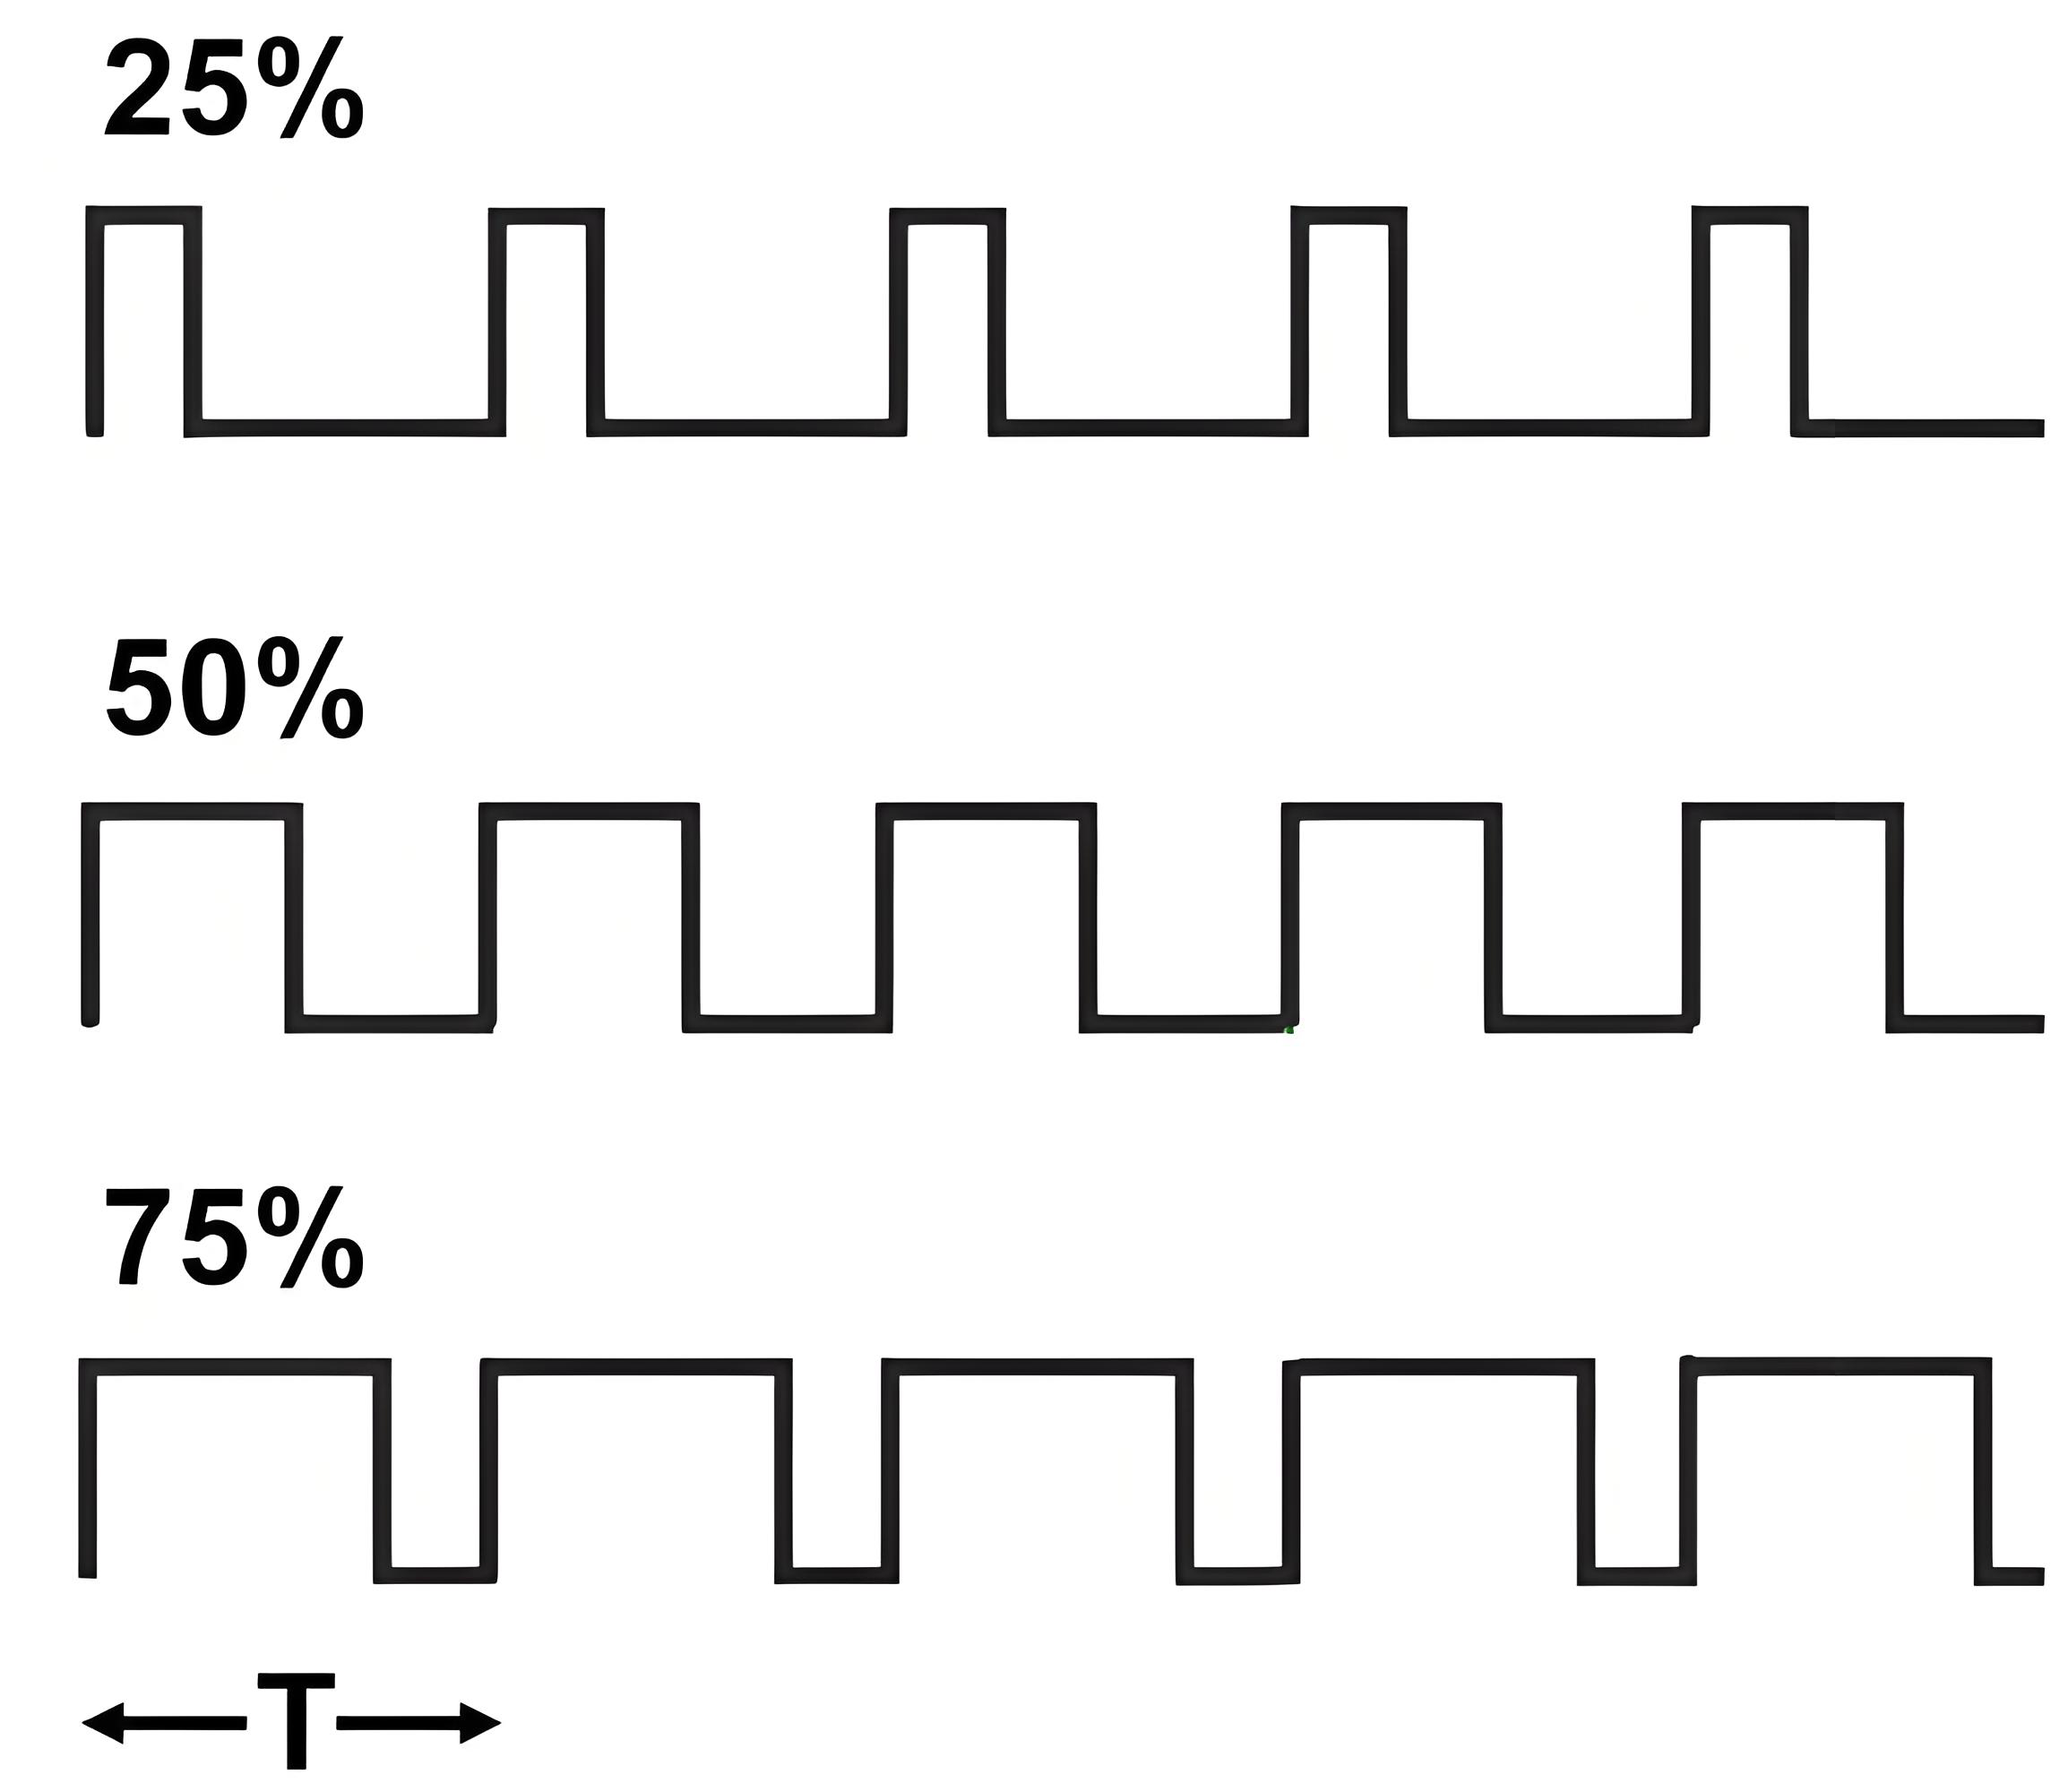

## 2. digilent xilinx IP 库
https://github.com/Digilent/vivado-library
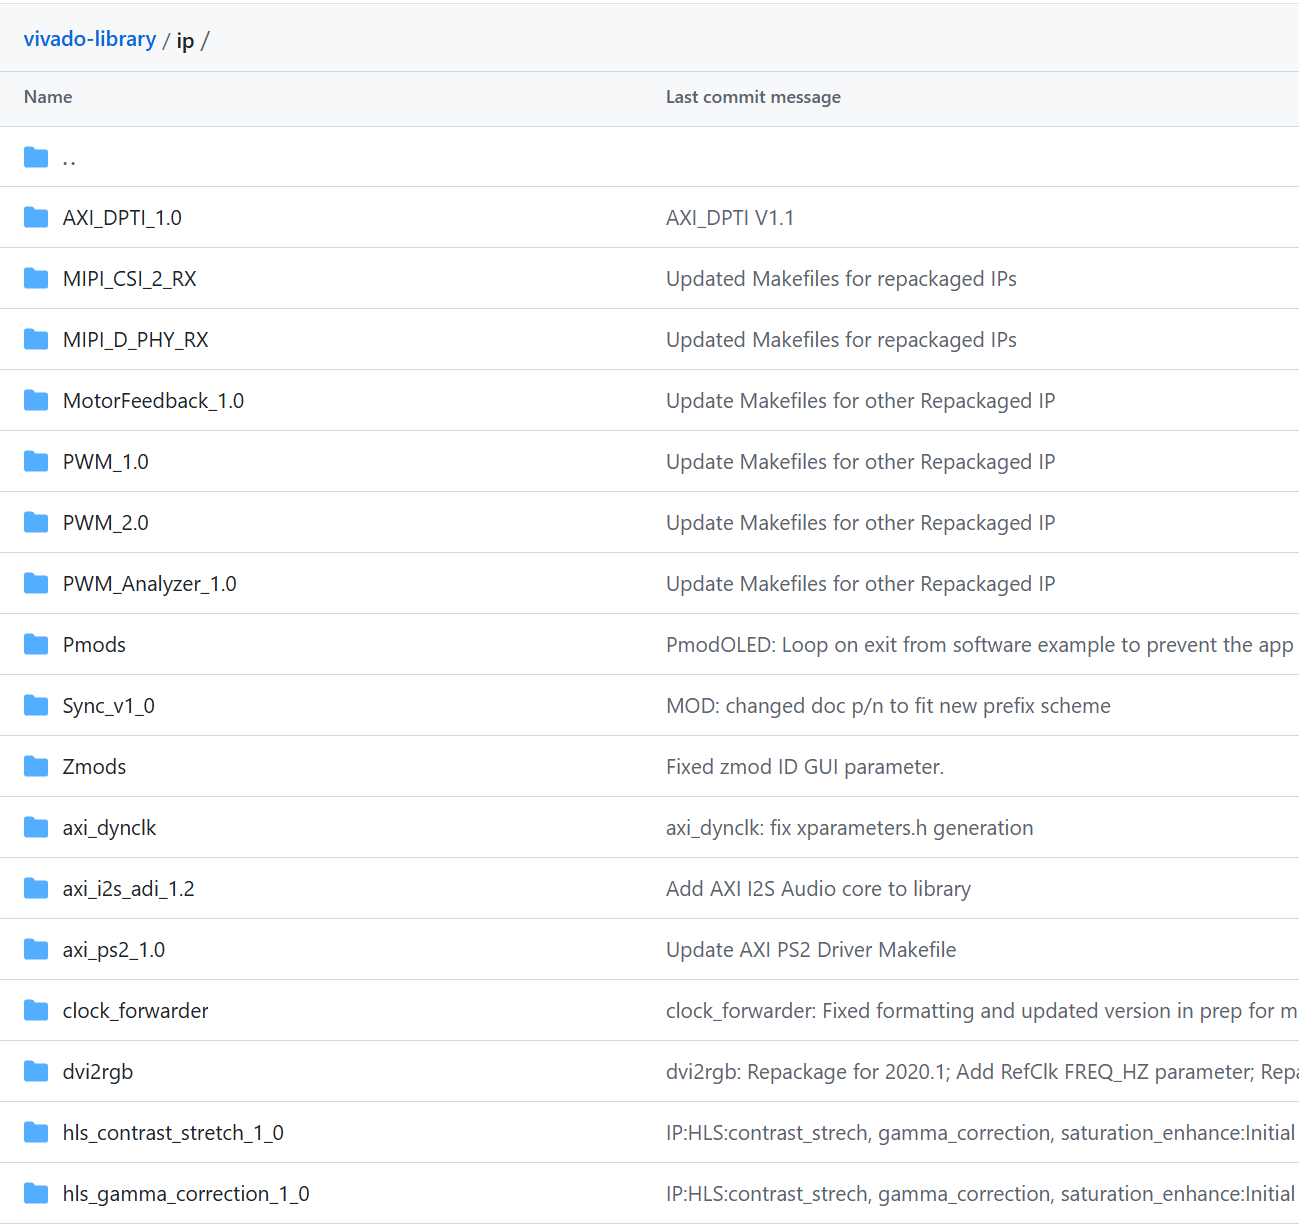

## 3. vivado中引入digilent xilinx IP 库
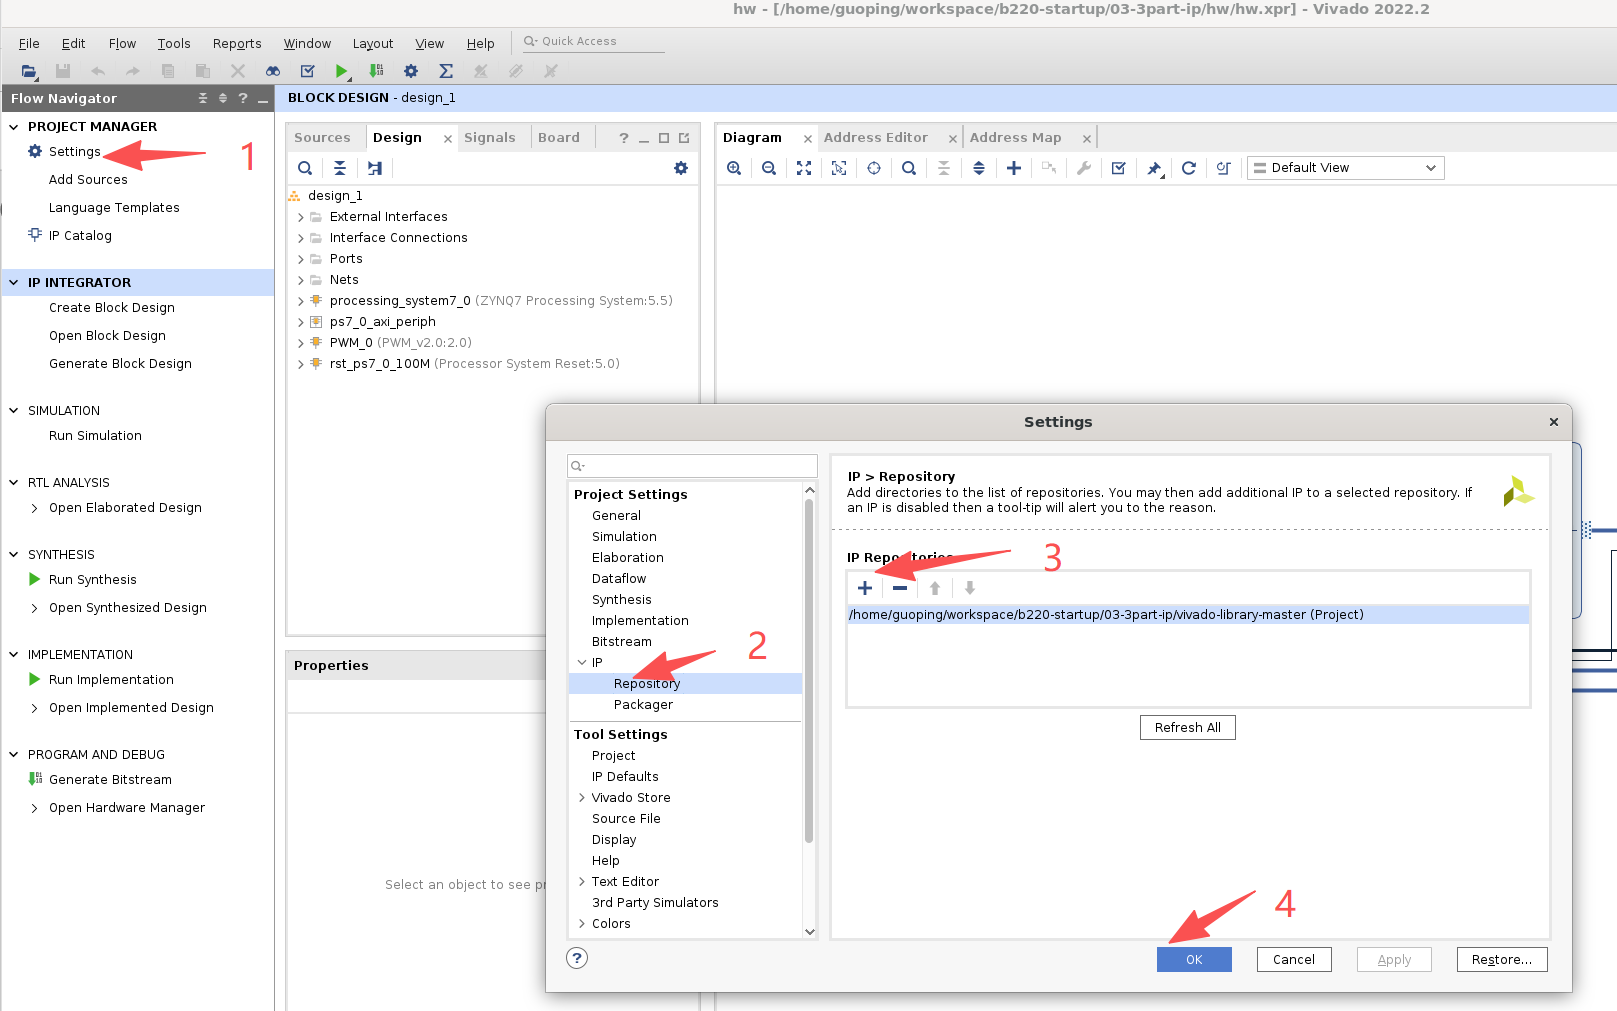

## 4. vivado中集成pwm 2.0 IP
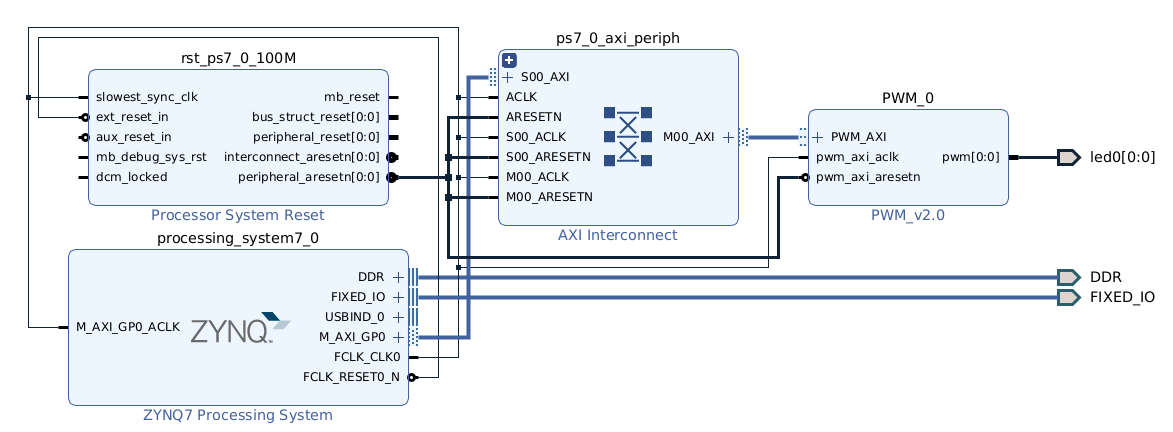

## 5. 确认一下pwm 2.0 IP在系统里的基地址
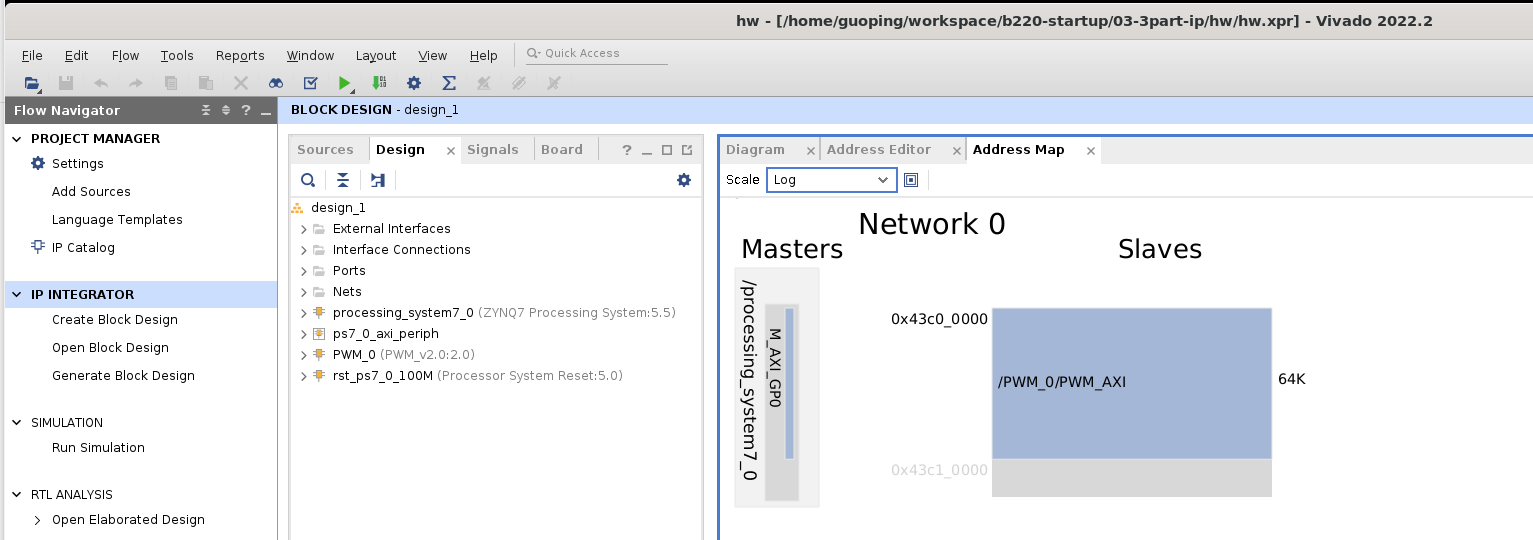

## 6. 生成系统的bitstream，export hardware的design_1.xsa文件，使用winrar软件由design_1.xsa压缩包里提取.bit和.hwh
并重命名为axi-pwm.bit和axi-pwm.hwh

## 7. pynq板上新建axi-pwm目录，在该目录下新建overlay目录，将第6步生成的.bit和.hwh拷贝至该目录

## 8. 拷贝pwm_driver.py至axi-pwm目录下

## 9. 新增一个ipynb文件，重命名为axi_pwm_demo

In [1]:
"""
首先，引入Overlay类
"""

from pynq import Overlay

## 10. 加载FPGA硬件设计bitstream

In [2]:
ol = Overlay("./overlay/axi-pwm.bit")

## 11. 引入自定义pwm_driver

In [3]:
"""
axi4-lite controlled pwm IP Driver for PYNQ
Provides Python interface to control the axi4-lite pwm IP core
"""

from pwm_driver import PWM

## 12. 根据第5小节信息，使用0x43C00000基地址

In [4]:
pwm = PWM(0x43C00000, "Main_PWM")

In [5]:
# 执行自检
if pwm.self_test():
    print("PWM self-test passed")
else:
    print("PWM self-test failed")

PWM self-test passed


In [6]:
# 配置PWM
pwm.set_period(1000)          # 设置周期为1000个时钟周期
pwm.set_duty(500, 0)          # 设置通道0占空比为500个时钟周期（50%）
pwm.set_duty(300, 1)          # 设置通道1占空比为300个时钟周期（30%）

# 使能PWM输出
pwm.enable()

# 读取当前配置
print(f"Current period: {pwm.get_period()}")
print(f"Channel 0 duty: {pwm.get_duty(0)}")

# 禁用PWM输出
pwm.disable()

Current period: 1000
Channel 0 duty: 500


# 实验要求：使用上述overlay和pwm_driver，控制led0，形成“呼吸灯”

In [7]:
import time

class BreathingLED:
    def __init__(self, pwm_base_addr, pwm_channel=0, freq=100):
        """初始化呼吸灯
        
        参数:
            pwm_base_addr: PWM控制器基地址（需根据硬件修改）
            pwm_channel: 连接LED的PWM通道（默认0）
            freq: PWM频率（Hz，建议100~1000，避免闪烁）
        """
        # 初始化PWM控制器
        self.pwm = PWM(pwm_base_addr, device_name="Breathing_LED_PWM")
        self.channel = pwm_channel
        
        # 验证PWM功能是否正常
        if not self.pwm.self_test():
            raise RuntimeError("PWM控制器自检失败，请检查硬件连接")
        
        # 计算周期（时钟周期数）：假设系统时钟为100MHz（10ns周期）
        # 周期 = 系统时钟频率 / PWM频率
        self.system_clk = 100_000_000  # 100MHz，需根据实际硬件修改
        self.period = int(self.system_clk / freq)  # 一个PWM周期的时钟数
        self.pwm.set_period(self.period)
        
        # 呼吸灯参数
        self.step = 1000  # 占空比变化步长（步长越小，过渡越平滑）
        self.delay = 0.01  # 每步延时时间（秒），控制呼吸速度
        
    def start(self, cycles=0):
        """启动呼吸灯效果
        
        参数:
            cycles: 呼吸循环次数（0表示无限循环）
        """
        print(f"启动呼吸灯（通道{self.channel}），按Ctrl+C停止")
        self.pwm.enable()  # 使能PWM输出
        
        try:
            count = 0
            while cycles == 0 or count < cycles:
                # 阶段1：从暗到亮（占空比从0增加到最大）
                for duty in range(0, self.period + 1, self.step):
                    self.pwm.set_duty(duty, self.channel)
                    time.sleep(self.delay)
                
                # 阶段2：从亮到暗（占空比从最大减小到0）
                for duty in range(self.period, -1, -self.step):
                    self.pwm.set_duty(duty, self.channel)
                    time.sleep(self.delay)
                
                count += 1
                
        except KeyboardInterrupt:
            print("\n用户中断，停止呼吸灯")
        finally:
            # 退出时关闭LED（占空比0）
            self.pwm.set_duty(0, self.channel)
            self.pwm.disable()
            print("呼吸灯已停止")

In [ ]:
# 配置参数（需根据实际硬件修改）
PWM_BASE_ADDR = 0x43C00000  # PWM控制器基地址（示例值）
LED_PWM_CHANNEL = 0         # 连接LED的PWM通道
PWM_FREQ = 200              # PWM频率200Hz（人眼无闪烁）
    
# 创建呼吸灯实例并启动
led = BreathingLED(
    pwm_base_addr=PWM_BASE_ADDR,
    pwm_channel=LED_PWM_CHANNEL,
    freq=PWM_FREQ
    )
led.start(cycles=0)  # 0表示无限循环

启动呼吸灯（通道0），按Ctrl+C停止
